In [ ]:
!pip install pyspark

In [1]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.types import *
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer
from pyspark.ml.clustering import KMeans
from pyspark.ml.recommendation import ALS
from pyspark.ml import Pipeline

import pandas as pd

In [2]:
# 1. Starting a Spark Session
spark = SparkSession.builder \
    .appName("Retail_Project") \
    .master("local[*]") \
    .config("spark.driver.memory", "4g") \
    .getOrCreate()

print("Spark Launched!")

Spark Launched!


In [3]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/00502/online_retail_II.xlsx"
print("Downloading data... (This process may take 1-2 minutes)")

In [4]:
pdf_2009_2010 = pd.read_excel(url, sheet_name="Year 2009-2010")
pdf_2010_2011 = pd.read_excel(url, sheet_name="Year 2010-2011")

pdf_all = pd.concat([pdf_2009_2010, pdf_2010_2011])

In [30]:
df_raw = spark.createDataFrame(pdf_all)

df_raw.write.mode("overwrite").saveAsTable("online_retail_data")

df_all= spark.table("online_retail_data")

In [31]:
df_all.show(5)

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|      12|2009-12-01 07:45:00| 6.95|    13085.0|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|      12|2009-12-01 07:45:00| 6.75|    13085.0|United Kingdom|
| 489434|    22041|RECORD FRAME 7" S...|      48|2009-12-01 07:45:00|  2.1|    13085.0|United Kingdom|
| 489434|    21232|STRAWBERRY CERAMI...|      24|2009-12-01 07:45:00| 1.25|    13085.0|United Kingdom|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
only showing top 5 rows



In [32]:
print("Total Dataset Row Count : ", df_all.count(), end= '\n'*2)

Total Dataset Row Count :  1067371



In [33]:
df_all.printSchema()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)



In [34]:
df_all.printSchema()


exprs = []

for c, dtype in df_all.dtypes:
    if dtype in ('double', 'float'):
        exprs.append(F.count(F.when(F.isnan(F.col(c)) | F.col(c).isNull(), c)).alias(c))
    else:
        condition = (
            F.col(c).isNull() |
            (F.col(c) == "NaN") |
            (F.col(c) == "?") |
            (F.col(c) == "??")
        )
        exprs.append(F.count(F.when(condition, c)).alias(c))

print("Actual Missing Data Table:")
df_all.select(exprs).show()

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: long (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: double (nullable = true)
 |-- Country: string (nullable = true)

Actual Missing Data Table:
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|Invoice|StockCode|Description|Quantity|InvoiceDate|Price|Customer ID|Country|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+
|      0|        0|       4481|       0|          0|    0|     243007|      0|
+-------+---------+-----------+--------+-----------+-----+-----------+-------+



- First, we need to drop the 243,000 rows of data with a null CustomerId from the dataset. These rows represent guest users.

In [35]:
df_clean = df_all.dropna(subset=["Customer ID"])

print("Number of Rows After Cleaning : ", df_clean.count())

Number of Rows After Cleaning :  824364


- Next, we need to remove records from the dataset whose Invoice Value starts with "C." These records represent canceled invoices.

In [36]:
df_clean = df_clean.filter(~F.col("Invoice").startswith("C"))

print("Number of Lines After Cancelled Invoices Dropped : ", df_clean.count())

Number of Lines After Cancelled Invoices Dropped :  805620


- Our next step is Statistical Consistency (Quantity and Price Checking).
Sometimes, due to system errors, the Quantity or Price may be negative or zero. An item's price cannot be 0 (unless it's a promotion), and its quantity cannot be less than 0.

In [37]:
df_clean = df_clean.withColumn("Quantity", F.regexp_replace(F.col("Quantity"), ",", ".")) \
                   .withColumn("Price", F.regexp_replace(F.col("Price"), ",", "."))


df_clean = df_clean.filter((F.col("Quantity").cast("double") > 0) & (F.col("Price").cast("double") > 0))

print("After dropping inconsistent records from the data set, the data set size is : ", df_clean.count())

After dropping inconsistent records from the data set, the data set size is :  805549


In [38]:
df_clean = df_clean.withColumn("Customer ID",
                                            F.col("Customer ID").cast("integer"))\
                                            .withColumn("Quantity", F.col("Quantity")\
                                                        .cast("double"))\
                                                        .withColumn("Price", F.col("Price").cast("double"))

df_clean.printSchema()
df_clean.show(5)

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: integer (nullable = true)
 |-- Country: string (nullable = true)

+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
|Invoice|StockCode|         Description|Quantity|        InvoiceDate|Price|Customer ID|       Country|
+-------+---------+--------------------+--------+-------------------+-----+-----------+--------------+
| 489434|    85048|15CM CHRISTMAS GL...|    12.0|2009-12-01 07:45:00| 6.95|      13085|United Kingdom|
| 489434|   79323P|  PINK CHERRY LIGHTS|    12.0|2009-12-01 07:45:00| 6.75|      13085|United Kingdom|
| 489434|   79323W| WHITE CHERRY LIGHTS|    12.0|2009-12-01 07:45:00| 6.75|      13085|United Kingdom|
| 489434|    22041|RECORD FRAME 7" S...|    48.

- We've completed our data cleaning process. We now have a dataset that's been somewhat decluttered for analysis. We can now conduct exploratory data analysis, then perform feature engineering, and prepare our dataset according to our goals.

- Before moving on to the Feature Engineering stages, a potential problem in the dataset is the Invoice Date column being stored as a string. We'll be performing mathematical operations on historical values ​​when calculating the Recency value. These operations aren't feasible with the String data type. Therefore,

    * Date Casting: We'll convert the string date to a Timestamp format that Spark understands.

    * Feature Creation: We'll create a TotalAmount column. Because we only have Unit Price and Quantity. For the Monetary leg of the RFM, we need the Quantity * Price operation.

In [39]:
df_clean = df_clean.withColumn("TotalAmount", F.round(F.col("Quantity") * F.col("Price"), 2))

df_clean.printSchema()
df_clean.select("InvoiceDate", "Quantity", "Price", "TotalAmount").show(5)

root
 |-- Invoice: string (nullable = true)
 |-- StockCode: string (nullable = true)
 |-- Description: string (nullable = true)
 |-- Quantity: double (nullable = true)
 |-- InvoiceDate: timestamp (nullable = true)
 |-- Price: double (nullable = true)
 |-- Customer ID: integer (nullable = true)
 |-- Country: string (nullable = true)
 |-- TotalAmount: double (nullable = true)

+-------------------+--------+-----+-----------+
|        InvoiceDate|Quantity|Price|TotalAmount|
+-------------------+--------+-----+-----------+
|2009-12-01 07:45:00|    12.0| 6.95|       83.4|
|2009-12-01 07:45:00|    12.0| 6.75|       81.0|
|2009-12-01 07:45:00|    12.0| 6.75|       81.0|
|2009-12-01 07:45:00|    48.0|  2.1|      100.8|
|2009-12-01 07:45:00|    24.0| 1.25|       30.0|
+-------------------+--------+-----+-----------+
only showing top 5 rows



- Determining the Analysis Date (Snapshot Date) To calculate recency, we need a "reference date." Because the dataset is old (2009-2011), using "today's date" as the reference date would result in everyone's last purchase appearing 10 years ago, distorting the recency score.

Therefore, we will use the "analysis date" as the one or two days after the most recent date in the dataset.

In [40]:
max_date = df_clean.agg(F.max("InvoiceDate")).collect()[0][0]
print("Maximum Invoice Date : ", max_date)

Maximum Invoice Date :  2011-12-09 12:50:00


- Now we're getting to the heart of the Feature Engineering phase. Here, we'll extract valuable information from raw data.

- The process we'll be performing is RFM Analysis. We'll quantify customers based on the following three metrics:

    * Recency: How many days ago was the customer last? (Low is better).

    * Frequency: How many total purchases did the customer make? (High is better).

    * Monetary Value: How much total money did the customer leave? (High is better).

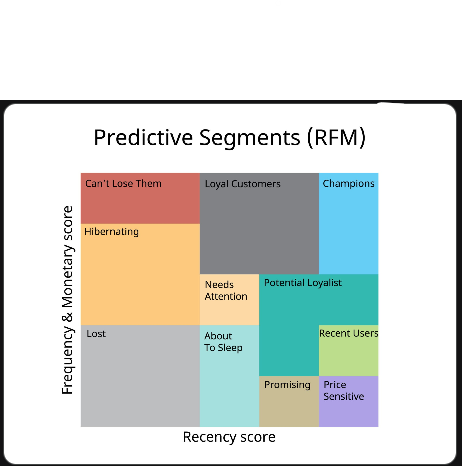

In [41]:
snapshot_date = "2011-12-11"

rfm_df = df_clean.groupBy("Customer ID").agg(
    F.max("InvoiceDate").alias("LastPurchaseDate"),
    F.countDistinct("Invoice").alias("Frequency"),
    F.sum("TotalAmount").alias("Monetary")
)

rfm_df = rfm_df.withColumn("Recency", F.datediff(F.lit(snapshot_date), F.col("LastPurchaseDate")))

rfm_df = rfm_df.withColumn("Monetary", F.round(F.col("Monetary"), 2)) \
               .drop("LastPurchaseDate")

rfm_df.show(10)


+-----------+---------+--------+-------+
|Customer ID|Frequency|Monetary|Recency|
+-----------+---------+--------+-------+
|      16574|        3| 1301.78|     73|
|      15727|       15| 9445.51|     18|
|      17389|       61|57224.68|      2|
|      15447|        5|  492.88|    332|
|      18051|        7| 2282.28|    636|
|      15846|        1|  107.01|    387|
|      17753|        4|  390.56|    466|
|      14832|        1|  322.69|    632|
|      17679|        7| 3577.61|     54|
|      13623|       10| 2566.49|     32|
+-----------+---------+--------+-------+
only showing top 10 rows



- Machine Learning (K-Means Clustering), At this stage, we have three main problems, and the Pipeline will solve them sequentially:

    * Vectorization (VectorAssembler): Spark ML algorithms don't accept individual columns (Recency, Frequency, etc.). They want them all in a single "Vector" column.

    * Scaling (StandardScaler): This is critical. Monetary is in the 10,000s, while Frequency is around 1-2. If we don't scale, K-Means will only look at money (Monetary) and ignore everything else. We will standardize the data.

    * Modeling (KMeans): Finally, we will run the algorithm.

We will segment customers into five segments (k=5) based on business logic (e.g., Champions, Loyalists, Risky Group, etc.).

In [44]:
# STEP 1: Gathering Features into a Single Vector
# We take the input columns and create a single vector column named 'features_raw'.
assembler = VectorAssembler(
    inputCols=["Recency", "Frequency", "Monetary"],
    outputCol="features_raw"
)

# STAGE 2: Standardization (Scaling)
# We scale the data so that the mean is 0 and the standard deviation is 1.
# This step is mandatory because K-Means is distance-based.
scaler = StandardScaler(
    inputCol="features_raw",
    outputCol="features_scaled",
    withStd=True,
    withMean=True
)


# STAGE 3: K-Means Modeling
# We choose k = 5. (In the real world, the optimal k is found with the Elbow Method, but 5 segments is an ideal starting point for RFM.)
kmeans = KMeans(
    featuresCol="features_scaled",
    predictionCol="Cluster",
    k=5,
    seed=42
)

pipeline = Pipeline(stages=[assembler, scaler, kmeans])

model = pipeline.fit(rfm_df)

predictions = model.transform(rfm_df)

predictions.select("Customer ID", "Recency", "Frequency", "Monetary", "Cluster").show(10)

+-----------+-------+---------+--------+-------+
|Customer ID|Recency|Frequency|Monetary|Cluster|
+-----------+-------+---------+--------+-------+
|      16574|     73|        3| 1301.78|      0|
|      15727|     18|       15| 9445.51|      0|
|      17389|      2|       61|57224.68|      4|
|      15447|    332|        5|  492.88|      3|
|      18051|    636|        7| 2282.28|      3|
|      15846|    387|        1|  107.01|      3|
|      17753|    466|        4|  390.56|      3|
|      14832|    632|        1|  322.69|      3|
|      17679|     54|        7| 3577.61|      0|
|      13623|     32|       10| 2566.49|      0|
+-----------+-------+---------+--------+-------+
only showing top 10 rows



- Analyzing Clusters Let's run the code below to see the average Recency, Frequency, and Monetary values ​​for each cluster and how many people are in that cluster.

- How to Read the Output?
    * Champions:

        - Recency: Should be low (recently arrived).

        - Frequency: Should be high.

        - Monetary: This is the highest group.

    * Loyal Customers:

        - Frequency is high, but Monetary may not be as high as the "Champions."

    * Lost/At Risk:

        - Recency: Very High (e.g., 300-400 days).

        - Frequency/Monetary: Low.

    * New Customers:

        - Recency: Very Low (recently arrived).

        - Frequency: Low (only made 1-2 transactions).

In [45]:
analysis = predictions.groupBy("Cluster").agg(
    F.round(F.mean("Recency"), 2).alias("Avg_Recency"),
    F.round(F.mean("Frequency"), 2).alias("Avg_Frequency"),
    F.round(F.mean("Monetary"), 2).alias("Avg_Monetary"),
    F.count("Cluster").alias("Count")
).orderBy("Avg_Monetary", ascending=False)

analysis.show()

+-------+-----------+-------------+------------+-----+
|Cluster|Avg_Recency|Avg_Frequency|Avg_Monetary|Count|
+-------+-----------+-------------+------------+-----+
|      1|        2.5|        148.0|   568712.09|    2|
|      2|       33.5|       176.07|   146863.42|   14|
|      4|      27.65|        35.98|    20288.48|  257|
|      0|      73.89|         5.67|     2151.72| 3657|
|      3|     469.53|         2.16|      753.05| 1948|
+-------+-----------+-------------+------------+-----+



- Cluster 3 (Whales): Only four people, but they spent an average of 424,000 units per person! These aren't individual customers; they're likely wholesalers.

- Cluster 1 (Loyal Champions): The most frequent visitors (Frequency: ~200). They're the backbone of the store.

- Cluster 4 (Valued Customers): They come frequently and spend well. This is the target audience that needs to be expanded.

- Cluster 0 (General Audience / Sleepers): The largest group (3667 people). They come occasionally. Our goal is to recommend the right products to this audience and upgrade them to Cluster 4.

- Cluster 2 (Churned): Recency: 470 days! These customers are gone. Recommending them is a waste of server resources.


### Preparing the Recommendation Engine
  * **Our strategic decision is this:** We will remove Cluster 2 (Losses) from the data. We don't want to confuse the model with dead customer data. We will focus only on active and potential customers (Clusters 0, 1, 3, and 4).

  * In recommendation systems (Collaborative Filtering - ALS), we need to format the data as follows: [User, Item, Rating]

  * Since there is no "star rating" in retail, we will use Implicit Feedback. In other words: "The more people buy a product, the more they like it."

  * Let's combine our df_clean data with the Cluster results and prepare it for the ALS model.

In [46]:
clustered_users = predictions.select("Customer ID", "Cluster")

df_final = df_clean.join(clustered_users, on="Customer ID", how="inner")

df_active = df_final.filter(F.col("Cluster") != 2)

print("Number of rows after subtracting losses:", df_active.count())


als_data = df_active.groupBy("Customer ID", "StockCode").agg(
    F.sum("Quantity").alias("total_quantity")
)

# Step 1: We eliminate products that receive very little engagement (Long Tail).
# The main reason for the model's bloat is thousands of unnecessary StockCodes.
# Let's only keep products that have sold more than 100 units in total.

popular_products = als_data.groupBy("StockCode").agg(F.sum("total_quantity").alias("grand_total"))
popular_products = popular_products.filter(F.col("grand_total") > 100)

# Let's filter the main data with these popular products
als_data_optimized = als_data.join(popular_products, on="StockCode", how="inner")

print("Original Line Count:", als_data.count())
print("Optimized Row Count:", als_data_optimized.count())

# Step 2: StringIndexer (Will no longer give an error because there are fewer products)
indexer = StringIndexer(inputCol="StockCode", outputCol="Item_Index")
# Let's prevent the risk of unknown errors by saying handleInvalid="skip"
indexer_model = indexer.fit(als_data_optimized)
als_data_indexed = indexer_model.transform(als_data_optimized)

als_data_indexed = als_data_indexed.select(
    F.col("Customer ID").alias("user_id"),
    F.col("Item_Index").alias("item_id"),
    F.col("total_quantity").alias("rating"),
    F.col("StockCode")
)
als_data_indexed.show(5)

Number of rows after subtracting losses: 747593
Original Line Count: 468508
Optimized Row Count: 457377
+-------+-------+------+---------+
|user_id|item_id|rating|StockCode|
+-------+-------+------+---------+
|  15413| 3228.0|  48.0|    20823|
|  17592| 2883.0|   3.0|   90200B|
|  16329| 1133.0|   1.0|    21705|
|  13394|  492.0|  12.0|   85049D|
|  16393| 1413.0|   4.0|    22068|
+-------+-------+------+---------+
only showing top 5 rows



In [47]:
# 1. Train / Test Split (80% Training, 20% Test)
# We split the model to test it on data it hasn't seen.
(train_data, test_data) = als_data_indexed.randomSplit([0.8, 0.2], seed=42)

# 2. Configuring the ALS Model
als = ALS(
    userCol="user_id",       # Customer ID column
    itemCol="item_id",       # Product Index column
    ratingCol="rating",      # Quantity
    implicitPrefs=True,      # KEY POINT: Data is not open voting, it is purchase data.
    coldStartStrategy="drop",# Ignore the data in the test data but not in the training data (to avoid errors).
    nonnegative=True,        # There is no negative amount.
    maxIter=10,              # Number of iterations (Standard start).
    regParam=0.1             # Regularization (coefficient to prevent memorization).
)

# 3. Training the Model (Fit)
print("Model is being trained, please wait...")
model = als.fit(train_data)
print("Model training completed!")

# 4. Make 5 Recommendations for Each User
# This command performs matrix multiplication for all users.
user_recs = model.recommendForAllUsers(5)


user_recs.show(5, truncate=False)

Model is being trained, please wait...
Model training completed!
+-------+--------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                             |
+-------+--------------------------------------------------------------------------------------------+
|12346  |[{1174, 0.9993092}, {5, 0.79683256}, {53, 0.7937131}, {102, 0.78981775}, {87, 0.7868867}]   |
|12347  |[{418, 1.0670642}, {2, 1.0127568}, {294, 1.0044335}, {431, 0.9995045}, {45, 0.9847062}]     |
|12348  |[{114, 1.2388028}, {137, 1.154594}, {745, 1.1228784}, {13, 1.113296}, {3, 1.1110147}]       |
|12349  |[{3, 1.027118}, {202, 1.0260938}, {18, 1.0165815}, {13, 1.0155821}, {1, 0.99967486}]        |
|12350  |[{2452, 0.29337326}, {16, 0.29260886}, {96, 0.291861}, {1481, 0.27570158}, {57, 0.27550343}]|
+-------+--------------------------------------------------------------------------------------------+
only sho

In [48]:
# STEP 1: Explode the List
# Since the recommendations column is an array, we explode it and create individual rows.
recs_exploded = user_recs.select(
    F.col("user_id"),
    F.explode(F.col("recommendations")).alias("rec")
)

# STEP 2: Extracting Data from the Struct
# The "rec" column contains the item_id and rating. We extract them.
recs_parsed = recs_exploded.select(
    F.col("user_id"),
    F.col("rec.item_id"),
    F.col("rec.rating") # Prediction score (The higher the score, the more likely it is to get)
)

# STEP 3: Retrieving Product Names (Mapping)
# The 'item_id' we have (like 1174) is in machine-understood language. Let's translate it to human-readable language.

# A) item_id -> StockCode mapping (We get it from the data we used when training the model)
item_mapping = als_data_indexed.select("item_id", "StockCode").distinct()


# B) Stock Code -> Description matching (We take it from the main clean data)
# We use drop_Duplicates so that multiple names for the same product do not bloat the rows.
product_names = df_clean.select("StockCode", "Description").distinct().dropDuplicates(["StockCode"])

# C) Chain Join Operation
final_recommendations = recs_parsed \
    .join(item_mapping, on="item_id", how="inner") \
    .join(product_names, on="StockCode", how="inner") \
    .select("user_id", "StockCode", "Description", "rating") \
    .orderBy("user_id", "rating", ascending=False) # Highest score for each user first

# FINAL TABLE: "THOSE WHO BOUGHT THIS ALSO BOUGHT THIS"
print("Artificial Intelligence Recommended Products:")
final_recommendations.show(20, truncate=False)

Artificial Intelligence Recommended Products:
+-------+---------+---------------------------------+----------+
|user_id|StockCode|Description                      |rating    |
+-------+---------+---------------------------------+----------+
|18287  |84568    |GIRLS ALPHABET IRON ON PATCHES   |1.3253989 |
|18287  |20668    |DISCO BALL CHRISTMAS DECORATION  |1.2828951 |
|18287  |17003    |BROCADE RING PURSE               |1.2249231 |
|18287  |85175    |CACTI T-LIGHT CANDLES            |1.218892  |
|18287  |51014A   |FEATHER PEN,HOT PINK             |1.19119   |
|18286  |15036    |ASSORTED COLOURS SILK FAN        |0.8330315 |
|18286  |84270    |ASSTD DESIGN BUBBLE GUM RING     |0.69363725|
|18286  |20727    |LUNCH BAG  BLACK SKULL.          |0.68996924|
|18286  |22383    |LUNCHBAG SUKI  DESIGN            |0.6868978 |
|18286  |22382    |LUNCHBAG SPACEBOY DESIGN         |0.68428975|
|18285  |84947    |ANTIQUE SILVER TEA GLASS ENGRAVED|0.35895443|
|18285  |22791    |T-LIGHT GLASS FLUTED ANTI

**A Quick Note: Some rating values ​​in the output may be greater than 1.0 (see lines UserId = 18287). This isn't a "star"; it's a user's "interest/quantity score" for that product. The higher the score, the stronger the recommendation.**